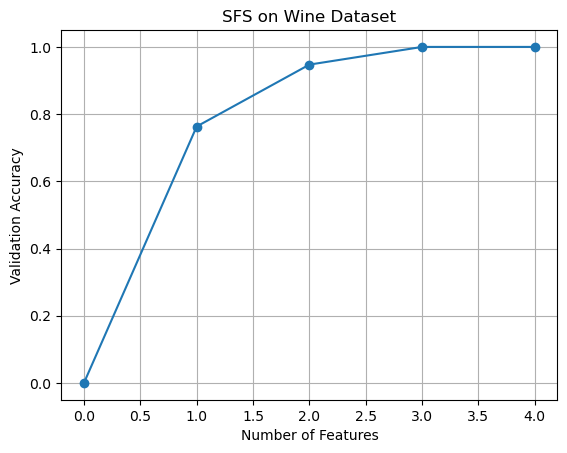

Selected Features: ['flavanoids', 'color_intensity', 'proline', 'alcalinity_of_ash']
Best Validation Accuracy: 1.0


In [1]:

import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.base import clone

# Load dataset
data = load_wine()
X = data.data
y = data.target
feature_names = data.feature_names

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)

# Standardize data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Modified SFS
class ForwardSelector:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.3, random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        self.scoring = scoring

    def fit(self, X, y):
        self.subsets_ = [()]
        self.scores_ = [0]
        self.indices_ = []
        self.feature_importance_ = np.zeros(X.shape[1])
        all_features = set(range(X.shape[1]))

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state)

        while len(self.indices_) < self.k_features:
            best_score = -np.inf
            best_feature = None
            for feature in all_features - set(self.indices_):
                candidate = self.indices_ + [feature]
                self.estimator.fit(X_train[:, candidate], y_train)
                preds = self.estimator.predict(X_val[:, candidate])
                score = self.scoring(y_val, preds)
                if score > best_score:
                    best_score = score
                    best_feature = feature
            self.indices_.append(best_feature)
            self.subsets_.append(tuple(self.indices_))
            self.scores_.append(best_score)
            self.feature_importance_[best_feature] = best_score

        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

# Apply to KNN
knn = KNeighborsClassifier(n_neighbors=3)
sfs = ForwardSelector(knn, k_features=4)
sfs.fit(X_train_std, y_train)

# Plot results
plt.plot([len(subset) for subset in sfs.subsets_], sfs.scores_, marker='o')
plt.title('SFS on Wine Dataset')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Output final results
selected_features = [feature_names[i] for i in sfs.indices_]
print("Selected Features:", selected_features)
print("Best Validation Accuracy:", sfs.k_score_)
